In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dpk import model_objs, koopman_probabilistic
import datetime as dt
import xarray as xr
sns.set_theme()

In [2]:
# reproducibility
seed = 633

print("[ Using Seed : ", seed, " ]")

import torch
import random
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

[ Using Seed :  633  ]


In [3]:
K = 200
name = "2018-19_gaussianOmega"
V = np.load(f"ristretto/{name}_rank{K}V.npy")
rank = 20
V = V[:, :rank]

In [5]:
scales = V.std(axis=0, keepdims=True)
x = V / scales

In [6]:
periods = np.array([24, 24 * 7, 24 * 365.24], dtype=np.float64)  # hours
l1width = 256
l2width = 1024
wd = 1e-3
lrt = 1e-4
# param_str = f"NormalNLL_{rank}_{l1width}_{l2width}_{32}_{900}_{seed}_{wd}_{lrt}"
model = model_objs.NormalNLL(x_dim=rank, num_freqs=3, n=l1width, n2=l2width)
# model.load_state_dict(torch.load(f"forecasts/model_{param_str}.pt"))

In [7]:
k = koopman_probabilistic.KoopmanProb(model, batch_size=32, device="cpu")
k.init_periods(periods)

In [8]:
total_iters = 0

In [15]:
iters = 900
total_iters += iters
k.fit(x, iterations=iters, cutoff=0, weight_decay=wd, lr_theta=lrt, lr_omega=0, verbose=True)

Iteration  0
tensor([  24.0000,  168.0000, 8765.7598,   24.0000,  168.0000, 8765.7598])
Setting periods to tensor([  24.0000,  168.0000, 8765.7598,   24.0000,  168.0000, 8765.7598],
       grad_fn=<MulBackward0>)
Loss:  0.21634974
Iteration  1
tensor([  24.0000,  168.0000, 8765.7598,   24.0000,  168.0000, 8765.7598])
Setting periods to tensor([  24.0000,  168.0000, 8765.7598,   24.0000,  168.0000, 8765.7598],
       grad_fn=<MulBackward0>)
Loss:  0.21459094
Iteration  2
tensor([  24.0000,  168.0000, 8765.7598,   24.0000,  168.0000, 8765.7598])
Setting periods to tensor([  24.0000,  168.0000, 8765.7598,   24.0000,  168.0000, 8765.7598],
       grad_fn=<MulBackward0>)
Loss:  0.21295741
Iteration  3
tensor([  24.0000,  168.0000, 8765.7598,   24.0000,  168.0000, 8765.7598])
Setting periods to tensor([  24.0000,  168.0000, 8765.7598,   24.0000,  168.0000, 8765.7598],
       grad_fn=<MulBackward0>)
Loss:  0.21131814
Iteration  4
tensor([  24.0000,  168.0000, 8765.7598,   24.0000,  168.0000, 

[0.21634974,
 0.21459094,
 0.21295741,
 0.21131814,
 0.20975502,
 0.20804866,
 0.20659128,
 0.20505013,
 0.20344031,
 0.20206055,
 0.20052007,
 0.19891538,
 0.1975526,
 0.19601998,
 0.1944941,
 0.19299555,
 0.19162285,
 0.19011451,
 0.18849966,
 0.18691108,
 0.18556978,
 0.18395156,
 0.18235295,
 0.1807451,
 0.1791141,
 0.17746,
 0.17581928,
 0.17396604,
 0.17217527,
 0.17052706,
 0.1687318,
 0.16695468,
 0.16512299,
 0.16329674,
 0.16144207,
 0.15953755,
 0.157649,
 0.15575112,
 0.15387721,
 0.15199645,
 0.15008858,
 0.14827001,
 0.14653637,
 0.14489827,
 0.14319977,
 0.1416733,
 0.14018911,
 0.13879538,
 0.13753287,
 0.13624902,
 0.13506822,
 0.13407919,
 0.13306333,
 0.13207833,
 0.13128653,
 0.13034049,
 0.12971254,
 0.12886532,
 0.128128,
 0.12740615,
 0.12682201,
 0.12604223,
 0.12528637,
 0.124723695,
 0.12415014,
 0.12333947,
 0.12267905,
 0.12207642,
 0.121343166,
 0.12069627,
 0.1200319,
 0.119165964,
 0.1186517,
 0.117965184,
 0.117302455,
 0.11666485,
 0.115973964,
 0.11519

In [16]:
current_date = dt.datetime(2020, 1, 1)
end_date = dt.datetime(2020, 3, 15)
increment = dt.timedelta(days=1)  # each file contains 1 day of data
T = ((end_date - current_date).days) * 24

H = V.shape[0] + T
params = k.predict(H)
params = model.rescale(loc=0, scale=scales, params=params)
mean_hat = model.mean(params)
std_hat = model.std(params)

In [17]:
param_str = f"NormalNLL_{rank}_{l1width}_{l2width}_{k.batch_size}_{total_iters}_{seed}_{wd}_{lrt}"
np.save(f"forecasts/params_{param_str}.npy", np.array(params))
torch.save(model.state_dict(), f"forecasts/model_{param_str}.pt")

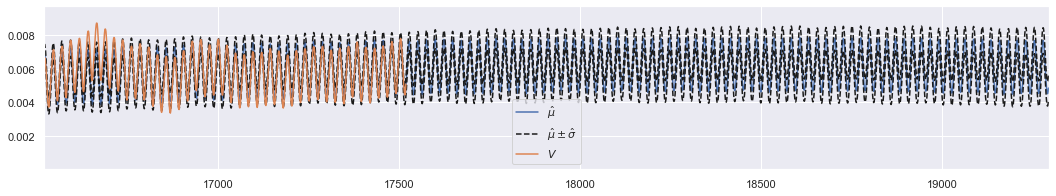

In [18]:
i = 0
plt.figure(figsize=(18, 3))
plt.plot(mean_hat[:, i], label="$\hat \mu$")
plt.plot(mean_hat[:, i] + std_hat[:, i], "--k", label="$\hat \mu \pm \hat \sigma$")
plt.plot(mean_hat[:, i] - std_hat[:, i], "--k")
plt.plot(V[:H, i], label="$V$")
plt.xlim([V.shape[0] - 1000, H])
plt.legend()

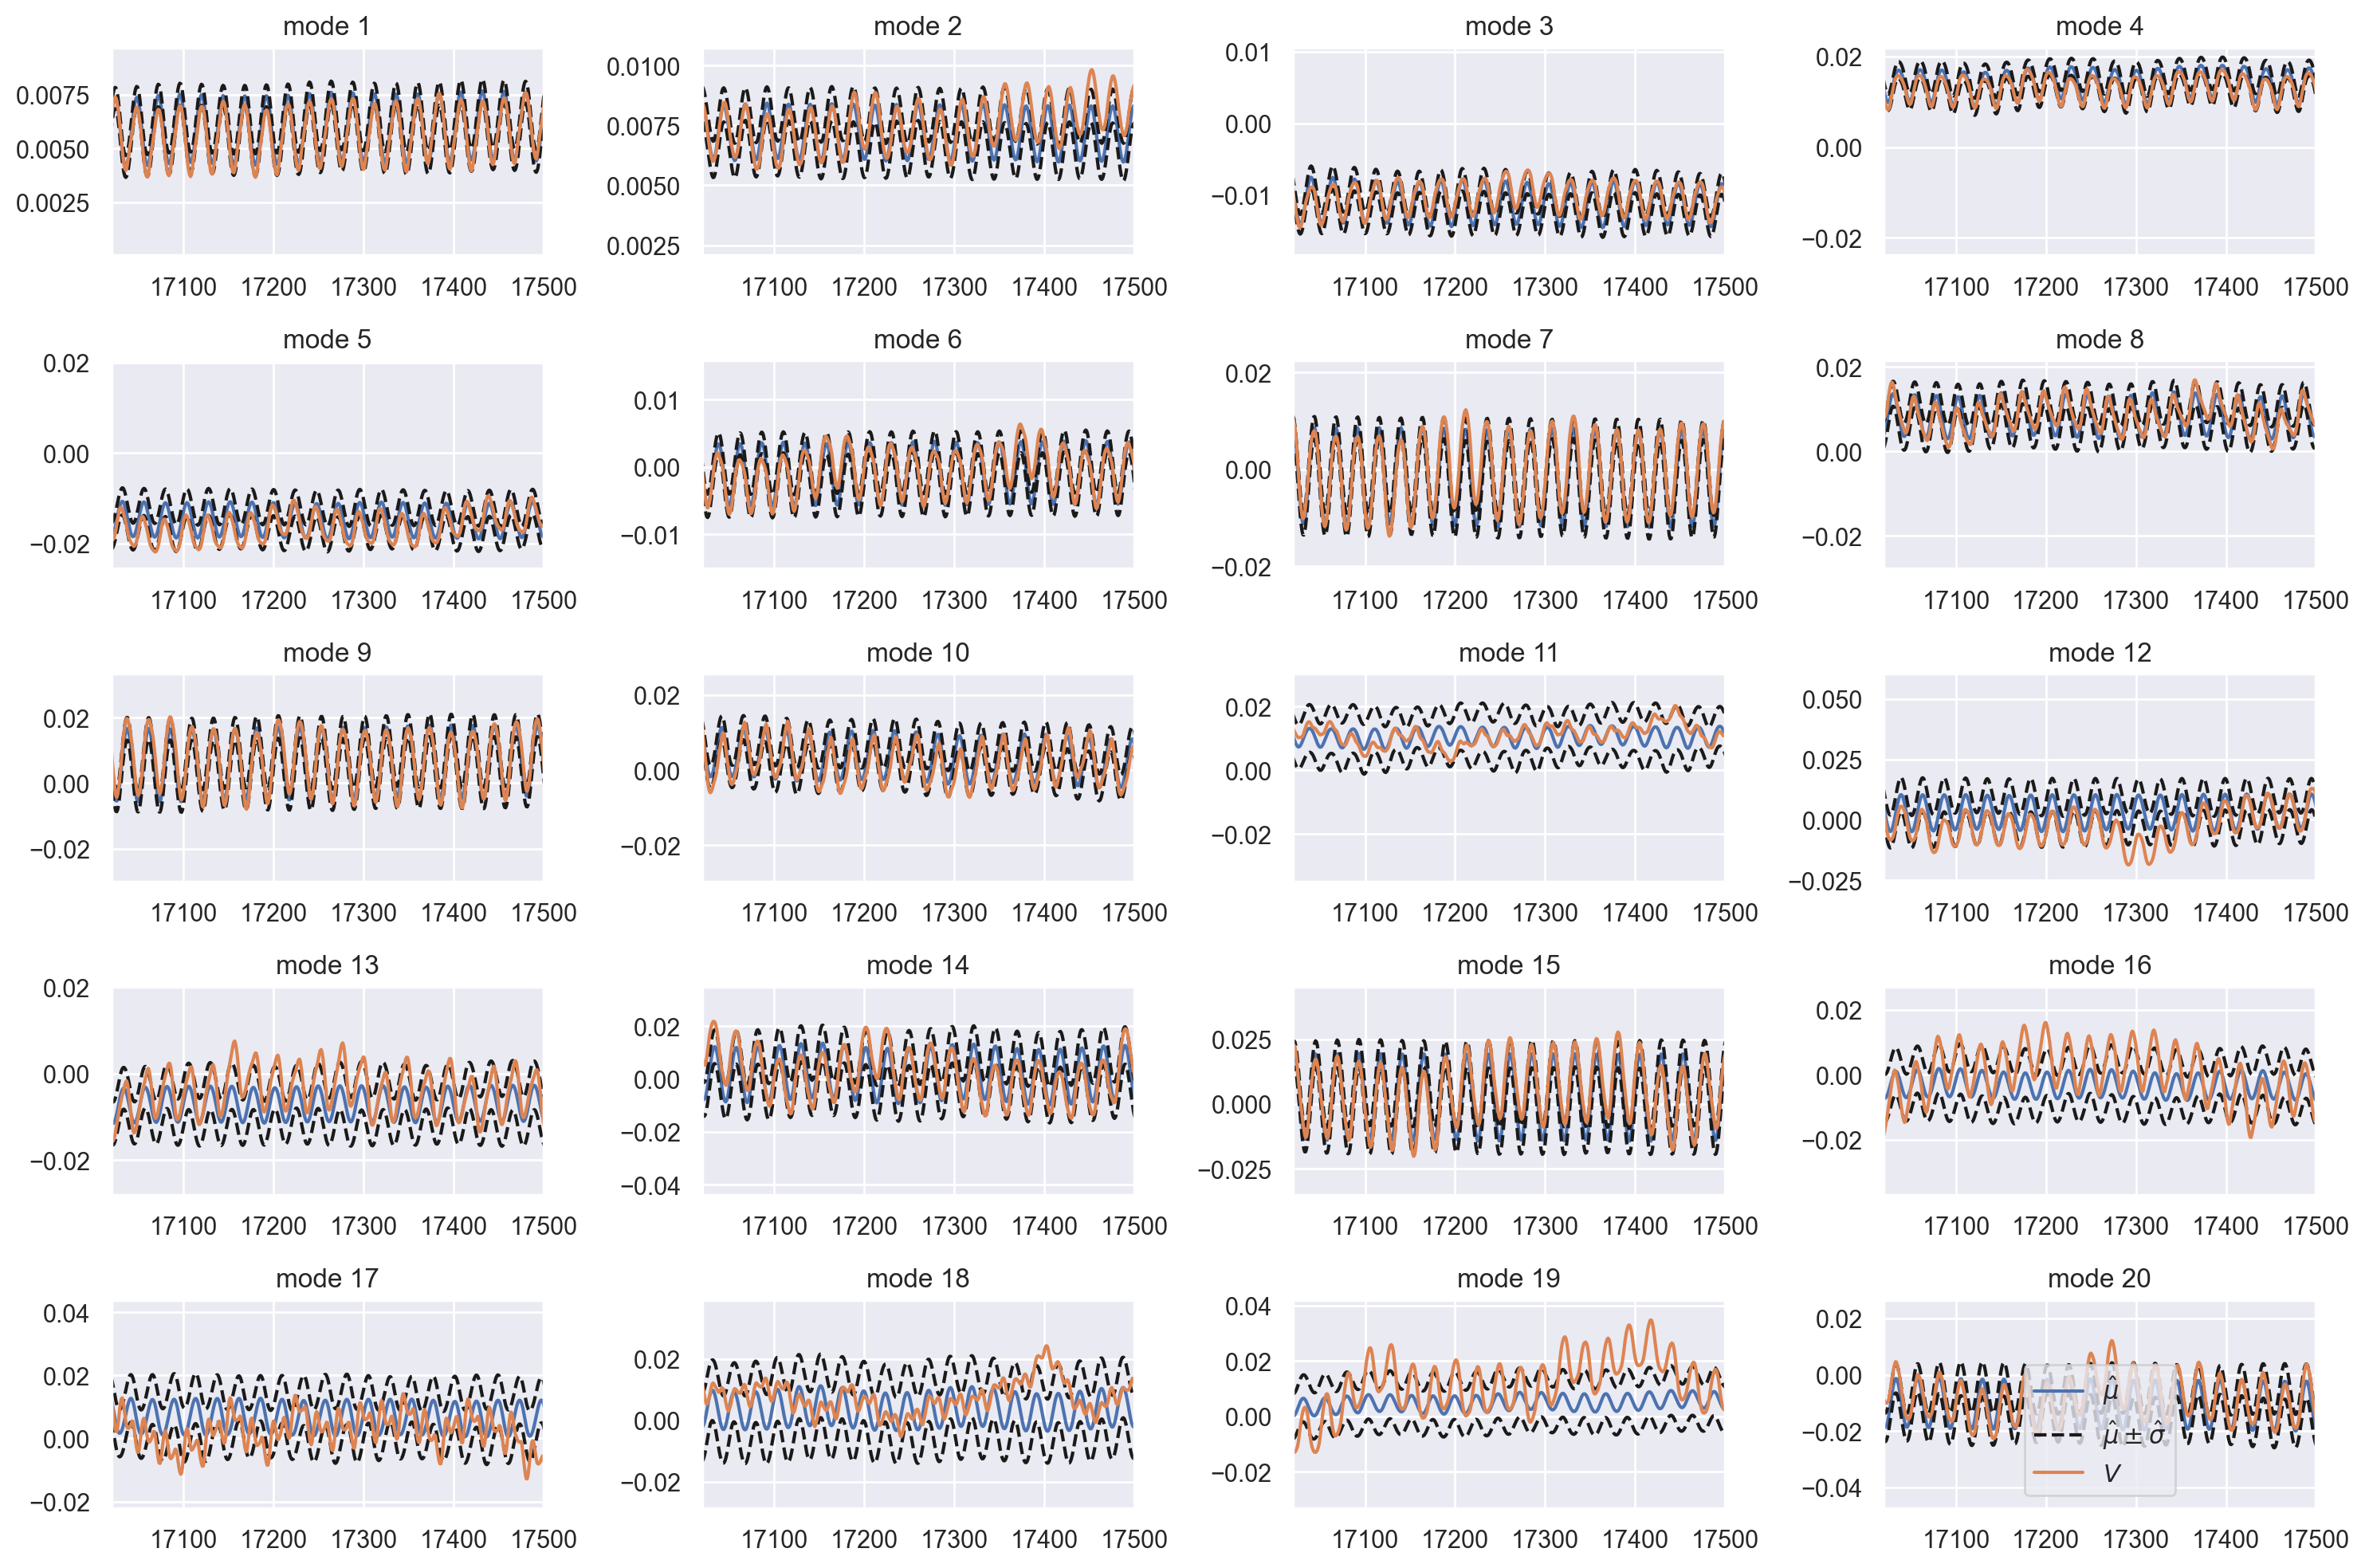

In [31]:
plt.subplots(5, 2, figsize=(15, 10), dpi=200)
start = 0
for i in range(start, start + rank):
    plt.subplot(5, 4, i + 1 - start)
    plt.title(f"mode {i + 1}")
    plt.plot(mean_hat[:, i], label="$\hat \mu$")
    plt.plot(mean_hat[:, i] + std_hat[:, i], "--k", label="$\hat \mu \pm \hat \sigma$")
    plt.plot(mean_hat[:, i] - std_hat[:, i], "--k")
    plt.plot(V[:H, i], label="$V$")
    plt.xlim([V.shape[0] - 500, 17500])
plt.tight_layout()
plt.legend()
plt.show()

# Compute MSE of central estimate

In [5]:
U = np.load(f"D:/atmo-chem/{name}_rank{K}U.npy")
spatial_means = np.load(f"ristretto/{name}_spatial_means.npy")
s = np.load(f"ristretto/{name}_rank{K}sigmas.npy")

In [8]:
sum(np.sqrt(s[:20])) / sum(np.sqrt(s))

0.3158600764275052

In [14]:
U.shape

(1038240, 200)

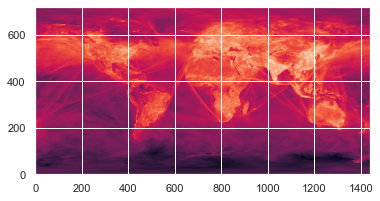

In [9]:
plt.imshow(spatial_means.reshape(721, 1440), origin="lower")

In [6]:
current_date = dt.datetime(2020, 1, 1)
end_date = dt.datetime(2020, 3, 15)
increment = dt.timedelta(days=1)  # each file contains 1 day of data
T = ((end_date - current_date).days) * 24

MSE = 0

t = V.shape[0]
while current_date < end_date:
    print("working on", current_date)
    data = xr.open_dataset(r"D:atmo-chem/data/NO2_" + str(current_date)[:10] + ".nc4")
    darr = data.to_array()[0, :, 0, :, :].to_numpy()  # remove elev and species dimensions
    
    flattened = darr.reshape((darr.shape[0], darr.shape[1] * darr.shape[2])).T  # flatten image
    
    A = np.log(flattened + 1e-30) - spatial_means
    
    # reconstruct A
    prediction = U[:, :rank] @ np.diag(s[:rank]) @ mean_hat[t:t + A.shape[1], :].T
    this_mse = ((prediction - A)**2)
    MSE += np.sum(this_mse / (A.shape[0] * T))
    print("\tMSE:", this_mse.mean())

    current_date += increment
    t += A.shape[1]
    

working on 2020-01-01 00:00:00


In [21]:
s

array([8.95434113e+04, 6.48560740e+04, 3.70457607e+04, 2.96284508e+04,
       2.79954434e+04, 2.32697704e+04, 1.58627856e+04, 1.53628885e+04,
       1.24793929e+04, 1.03992975e+04, 9.48516689e+03, 9.17984863e+03,
       8.91728016e+03, 7.52002670e+03, 7.21419474e+03, 6.81010016e+03,
       6.42340438e+03, 6.34503777e+03, 5.95680739e+03, 5.73906641e+03,
       5.28647419e+03, 5.26599194e+03, 5.02272977e+03, 4.76280184e+03,
       4.52645017e+03, 4.32516043e+03, 4.09447984e+03, 3.97354364e+03,
       3.84499434e+03, 3.63663640e+03, 3.55121537e+03, 3.31720820e+03,
       3.20569841e+03, 3.13623445e+03, 3.02789741e+03, 2.97143057e+03,
       2.77609283e+03, 2.75523633e+03, 2.65538177e+03, 2.57913687e+03,
       2.48604969e+03, 2.46001698e+03, 2.35125176e+03, 2.27671301e+03,
       2.24739676e+03, 2.15448026e+03, 2.12921966e+03, 2.08787103e+03,
       2.05865155e+03, 1.93432103e+03, 1.91298794e+03, 1.87575975e+03,
       1.78370285e+03, 1.76715963e+03, 1.74668096e+03, 1.65358269e+03,
      

In [17]:
A.std()

1.2667299047403908

C:\Users\ATMal\AppData\Local\Temp/ipykernel_25352/3119299818.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


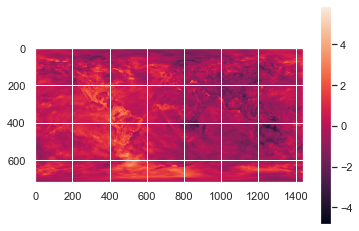

C:\Users\ATMal\AppData\Local\Temp/ipykernel_25352/3119299818.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


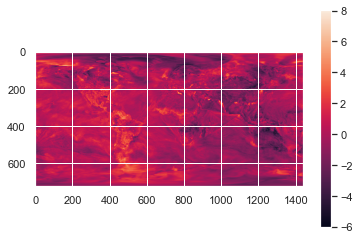

In [23]:
plt.imshow(prediction.reshape((721, 1440, 24))[::-1, :, 5])
plt.colorbar()
plt.show()
plt.imshow(A.reshape((721, 1440, 24))[::-1, :, 5])
plt.colorbar()
plt.show()

In [24]:
print("rank:", rank, "MSE:", MSE)

rank: 20 MSE: 0.5932410724866528


In [ ]:
print("rank:", rank, "MSE:", MSE)

rank: 50 MSE: 0.5755321660206213


In [ ]:
print("rank:", rank, "MSE:", MSE)

rank: 50 MSE: 0.5759224670516686


In [ ]:
print("rank:", rank, "MSE:", MSE)

rank: 10 MSE: 0.6489049180026171


In [164]:
print("rank:", rank, "MSE:", MSE)

rank: 20 MSE: 0.5945246015733084


In [147]:
print("rank:", rank, "MSE:", MSE)

rank: 5 MSE: 0.7064405227162223


In [135]:
print("rank:", rank, "MSE:", MSE)

rank: 4 MSE: 0.7701405817278341


In [123]:
print("rank:", rank, "MSE:", MSE)

rank: 3 MSE: 0.8346050727588257
